<a href="https://colab.research.google.com/github/Kimhy-git/Colab/blob/main/%EC%A7%80%EC%88%98%ED%8F%89%ED%99%9C%EB%B2%95_%EC%9E%90%EB%8F%99%ED%99%94.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###함수

In [69]:
# double or triple exponential smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import ast

In [70]:
# create class
def create_class(train, test, config):
  t,s,p,br,b,r = config
  model = ExponentialSmoothing(train, trend=t, seasonal=s, seasonal_periods=p)
  model_fit = model.fit(optimized=True, use_brute=br, use_boxcox=b, remove_bias=r)
  # make prediction
  start = test.index.to_pydatetime()[0]
  end = test.index.to_pydatetime()[12]
  predict = model_fit.predict(start=start, end=end)
  return predict


# read file
def read_file(file_name):
  data_path = '/content/drive/MyDrive/ColabNotebooks/prediction/ExponentialSmoothing/' + file_name + '.csv'
  data = pd.read_csv(data_path)
  data.set_index('date', inplace=True)
  data.index = pd.to_datetime(data.index)

  data['increase'] = data['increase'] + 10
  data['increase'] = np.log(data['increase'])

  # train data와 validation data 나누기
  train = data[data.index <= '2021-03']
  test = data[data.index > '2021-03']

  return [train, test]

In [71]:
def model_evaluation(test, predict, graph):
  # test
  test_sns = test.reset_index()
  test_sns.columns = ['date', 'increase']

  x = test_sns.index
  y = test_sns['increase']

  line_fitter = LinearRegression()
  line_fitter.fit(x.values.reshape(-1,1), y)

  test_line = line_fitter.predict(x.values.reshape(-1,1))
  
  # predict
  pre_sns = predict.reset_index()
  pre_sns.columns = ['date', 'increase']

  a = pre_sns.index
  b = pre_sns['increase']

  line_fitter2 = LinearRegression()
  line_fitter2.fit(a.values.reshape(-1,1), b)

  pre_line = line_fitter2.predict(a.values.reshape(-1,1))

  # 가중치
  test_weight = line_fitter.coef_
  pre_weight = line_fitter2.coef_

  if graph is True:
    plt.plot(a, b , 'o')
    plt.plot(x, y , 'o')
    plt.plot(a, pre_line)
    plt.plot(x, test_line)
    plt.show()
    
  weight_accuracy = abs(abs(test_weight) - abs(pre_weight))[0]
  # print('가중치의 차이값:', weight_accuracy)
  return weight_accuracy

In [72]:
def exp_smoothing_configs():
  models = list()
  # define config lists
  t_params = ['add', 'mul', None]
  s_params = ['add', 'mul', None]
  p_params = [12]
  br_params = [True, False]
  b_params = [True, False]
  r_params = [True, False]

  # create config instances
  for t in t_params:
    for s in s_params:
      for p in p_params:
        for br in br_params:
          for b in b_params:
            for r in r_params:
              cfg = [t,s,p,br,b,r]
              models.append(cfg)

  return models

In [73]:
def walk_forward_validation(train, test, config):
  # print('walk_forward_validation')
  predict = create_class(train, test, config)
  return model_evaluation(test, predict, False)

In [74]:
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings

In [75]:
# score a model, return None on failure
def score_model(train, test, cfg, debug=False):
  # print('start score_model')
  result = None
  # convert config to a key
  key = str(cfg)
  # show all warnings and fail on exception if debugging
  if debug:
    result = walk_forward_validation(train, test, cfg)
  else:
    # one failure during model validation suggests an unstable config
    try:
      # never show warnings when grid searching, too noisy
      with catch_warnings():
        filterwarnings("ignore")
        result = walk_forward_validation(train, test, cfg)
    except:
      error = None
  # check for an interesting result
  # if result is not None:
    # print(' > Model[%s] %.3f' % (key, result))
  return (key, result)


# grid search configs
def grid_search(train, test, cfg_list, parallel=True):
  # print('start grid_search')
  scores = None
  if parallel:
    # execute configs in parallel
    executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
    tasks = (delayed(score_model)(train, test, cfg) for cfg in cfg_list)
    scores = executor(tasks)
  else:
    scores = [score_model(train, test, cfg) for cfg in cfg_list]
  # remove empty results
  scores = [r for r in scores if r[1] != None]
  # sort configs by error, asc
  scores.sort(key=lambda tup: tup[1])
  return scores

###실행

In [80]:
# 파일 불러오기
file_name = 'trade_test_010_exist'
train, test = read_file(file_name)

In [81]:
# model configs
cfg_list = exp_smoothing_configs()
print('cfg_list')
print(cfg_list)
# grid search
scores = grid_search(train, test, cfg_list)
print('done')
# list top 3 configs
config = list()
for cfg, error in scores[:1]:
  print(cfg, error)
  config = cfg

cfg_list
[['add', 'add', 12, True, True, True], ['add', 'add', 12, True, True, False], ['add', 'add', 12, True, False, True], ['add', 'add', 12, True, False, False], ['add', 'add', 12, False, True, True], ['add', 'add', 12, False, True, False], ['add', 'add', 12, False, False, True], ['add', 'add', 12, False, False, False], ['add', 'mul', 12, True, True, True], ['add', 'mul', 12, True, True, False], ['add', 'mul', 12, True, False, True], ['add', 'mul', 12, True, False, False], ['add', 'mul', 12, False, True, True], ['add', 'mul', 12, False, True, False], ['add', 'mul', 12, False, False, True], ['add', 'mul', 12, False, False, False], ['add', None, 12, True, True, True], ['add', None, 12, True, True, False], ['add', None, 12, True, False, True], ['add', None, 12, True, False, False], ['add', None, 12, False, True, True], ['add', None, 12, False, True, False], ['add', None, 12, False, False, True], ['add', None, 12, False, False, False], ['mul', 'add', 12, True, True, True], ['mul', 'add

In [82]:
config = ast.literal_eval(config)
print(config)

['mul', None, 12, True, True, True]


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


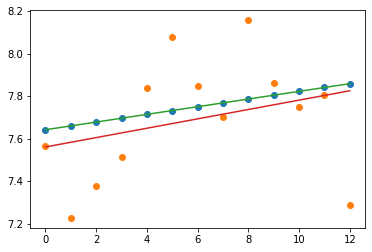

기울기의 차이값: 0.003972395985220433


In [83]:
predict = create_class(train, test, config)

weight_accuracy = model_evaluation(test, predict, True)
print('기울기의 차이값:', weight_accuracy)